# Introduction : objectives

To facilitate comparison with other models, it is necessary to have the same grid and resolution. In this notebook, the main objective is to build a tool to reproject footprint values onto a given grid. The hydrological model used is Parflow-CLM, which simulates the 3D water flow of a watershed located near the Lautaret flux tower.

# Importation of packages and modules

This notebook was developed with:  
- Python 3.13.2  
- Jupyter Notebook  
- Libraries : pandas, numpy, matplotlib, rasterio, rioxarray, xarray
- Modules : data_preparation, footprint_analysis
- See 'environment.yml' in the repository for more infos. 

In [48]:
import sys
sys.path.append('/home/jovyan//ICOS-M2-internship-alise/scripts/')

In [49]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import data_preparation as datprep
import footprint_analysis as FFP_analys
import rasterio
import rasterio.plot
import rioxarray
from rasterio.enums import Resampling
from rasterio.warp import reproject
import xarray as xr

import watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [50]:
%watermark --iversions

numpy     : 2.2.4
pandas    : 2.2.3
sys       : 3.13.2 | packaged by conda-forge | (main, Feb 17 2025, 14:10:22) [GCC 13.3.0]
scipy     : 1.15.2
contextily: 1.6.2
rioxarray : 0.19.0
watermark : 2.5.0
matplotlib: 3.10.1
xarray    : 2025.3.1
rasterio  : 1.4.3



# 1) Reproject the footprint onto another model grid

## Data importation

In [51]:
# Data importation
flux_NDVI = pd.read_csv('/home/jovyan//ICOS-M2-internship-alise/data_plots/flux_NDVI.csv')
flux_NDVI["TIMESTAMP_START"] = pd.to_datetime(flux_NDVI["TIMESTAMP_START"])

## Plot the model grid and the tower location on it

In [52]:
# Open the model grid
grid_path = '/mnt/data-summer-shared/ICOS_Data_AliseROBERT/Mask_10m_adj.tif'

with rasterio.open(grid_path) as src:
    grid = src.read(1)
    grid_transform = src.transform
    grid_crs = src.crs
    extent = rasterio.plot.plotting_extent(src)

In [53]:
# Set tower coordinates (longitude and latitude in WGS84, EPSG : 4326)
lon_tower = 6.410519
lat_tower = 45.041375

In [54]:
# Convert the tower coordinates (longitude, latitude) into position on the Parflow grid
x0_conv, y0_conv = FFP_analys.transform_coordinates(lon_tower, lat_tower, crs_in="EPSG:4326", crs_out=grid_crs)

# Get the tower position in the mesh (indices)
col, row = ~grid_transform * (x0_conv, y0_conv)
print(f"Position of the tower on the grid : column={float(col)}, row={float(row)}")

Position of the tower on the grid : column=56.90509498261963, row=34.23143311718013


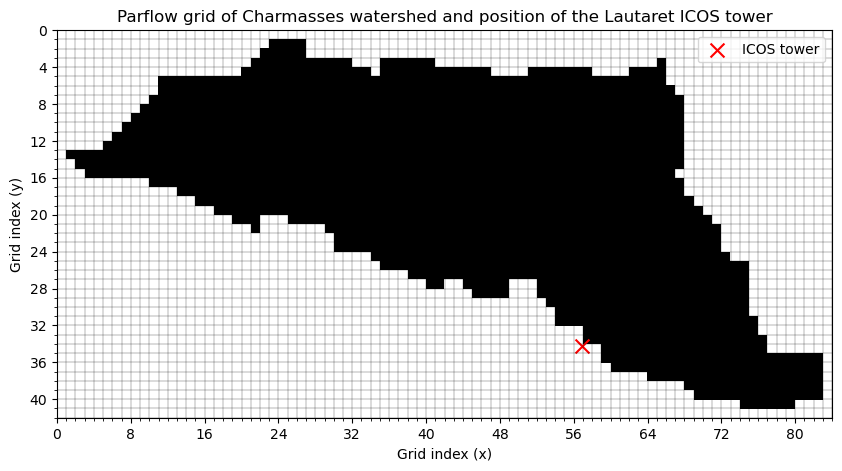

In [55]:
# Plot the model grid and the tower position
fig, ax = plt.subplots(figsize=(10, 10))

cax = ax.imshow(grid, cmap='gray', origin='upper', extent=extent)

# Grid
num_rows, num_cols = grid.shape
x_ticks = np.arange(0, num_cols + 1) * grid_transform.a + grid_transform.c
y_ticks = np.arange(0, num_rows + 1) * grid_transform.e + grid_transform.f

ax.set_xticks(x_ticks, minor=True)
ax.set_yticks(y_ticks, minor=True)
ax.grid(which='both', color='black', linestyle='-', linewidth=0.2)

# Add a cross for the tower position
ax.scatter(x0_conv, y0_conv, color='red', s=100, marker='x', label=f'ICOS tower')

ax.set_title("Parflow grid of Charmasses watershed and position of the Lautaret ICOS tower")
ax.set_xlabel('Grid index (x)')
ax.set_ylabel('Grid index (y)')
ax.legend()

# Index  on axis
col_indices = np.arange(0, num_cols + 1, max(1, num_cols // 10))
row_indices = np.arange(0, num_rows + 1, max(1, num_rows // 10))

ax.set_xticks(x_ticks[col_indices])
ax.set_xticklabels(col_indices)

ax.set_yticks(y_ticks[row_indices])
ax.set_yticklabels(row_indices)

plt.show()

This image illustrates the Parflow model grid with the indices of the mesh. Each black square represents an area where a value is provided by the model. The ICOS tower is located on the edge of the grid and not on a node, we need to artifically change the tower's location to facilitate reprojection.

### With that, calculate new coordinates for the tower position, on a nod of Parflow grid

In [56]:
x0_conv2 = x0_conv + 0.95 # To reach column = 57
y0_conv2 = y0_conv + 2.31 # To reach row = 34

## Example for stagnation/day

In [57]:
# Calculate the footprint climatology with 2.5 m resolution (multiple of 10, the resolution of Parflow grid)
clim_test_stagn_day = FFP_analys.run_FFP_nc(flux_NDVI[(flux_NDVI['phase_label'] == 'Stagnation') & (flux_NDVI['Night'] == False)])

## Formatting : footprint dictionary to tif

In [58]:
# Transform the x/y footprint grid to Lambert 93 coordinates (corrected regarding Parflow grid)
clim_test_stagn_day['x_2d'] = x0_conv2 + clim_test_stagn_day['x_2d']
clim_test_stagn_day['y_2d'] = y0_conv2 + clim_test_stagn_day['y_2d']

In [59]:
# Convert the footprint dictionary into a xarray Dataset
clim_stagn_day_ds = FFP_analys.FFPdict_to_nc(clim_test_stagn_day)

In [60]:
# Assign a spatial reference to footprint xarray (Lambert-93)
xr_footprint = clim_stagn_day_ds.footprint.rio.write_crs("EPSG:2154")
# Set dimension order (y,x is necessary for GeoTIFF)
xr_footprint = xr_footprint.transpose('y', 'x')
#Saving (change path if necessary)
xr_footprint.rio.to_raster("/mnt/data-summer-shared/ICOS_Data_AliseROBERT/footprint_test.tif")

In [61]:
# Check raster transform
print(xr_footprint.rio.transform())

| 2.50, 0.00, 967764.50|
| 0.00, 2.50, 6443113.95|
| 0.00, 0.00, 1.00|


## Resampling of footprint values from 2.5x2.5 to 10x10m grid (Parflow)

In [62]:
# Open footprint GeoTIFF
footprint_raster = rioxarray.open_rasterio('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/footprint_test.tif')

In [63]:
# Open Parflow grid geoTIFF into xarray
model_grid = rioxarray.open_rasterio('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/Mask_10m_adj.tif')

In [64]:
# Creating an empty array with Parflow grid dimensions
resampled = np.empty((model_grid.sizes['y'], model_grid.sizes['x']), dtype=footprint_raster.dtype)

In [65]:
# Reprojection of the fooprint values onto the Parflow grid, by addition
reproject(
    source=footprint_raster.values,
    destination=resampled,
    src_transform=footprint_raster.rio.transform(),
    src_crs=footprint_raster.rio.crs,
    dst_transform=model_grid.rio.transform(),
    dst_crs=model_grid.rio.crs,
    resampling=Resampling.sum
)

(array([[1.01271069e-08, 1.06109711e-08, 1.11494829e-08, ...,
         4.41007360e-07, 4.10189599e-07, 3.81652343e-07],
        [1.03653951e-08, 1.08221883e-08, 1.13312929e-08, ...,
         4.57422674e-07, 4.24813548e-07, 3.95305623e-07],
        [1.06788540e-08, 1.11132666e-08, 1.15956477e-08, ...,
         4.74585228e-07, 4.40620588e-07, 4.10616883e-07],
        ...,
        [1.34430390e-07, 1.43338627e-07, 1.53036420e-07, ...,
         1.96624337e-06, 1.73510544e-06, 1.53804142e-06],
        [1.47277251e-07, 1.57242624e-07, 1.68090083e-07, ...,
         2.00813105e-06, 1.77422115e-06, 1.57407341e-06],
        [1.61237636e-07, 1.72221774e-07, 1.84162444e-07, ...,
         2.03657080e-06, 1.80351831e-06, 1.60318256e-06]], shape=(42, 84)),
 Affine(10.0, 0.0, 967895.7469,
        0.0, -10.0, 6444155.203))

In [66]:
# Create a new xarray to store the reprojected values
footprint_resampled = xr.DataArray(
    resampled,
    coords={
        'y': model_grid.y,
        'x': model_grid.x
    },
    dims=['y', 'x'],
    name='footprint_resampled'
)

In [67]:
# Keep only the values on the cells covered by the Parflow model
footprint_masked = footprint_resampled.where(model_grid == 1)

## Plot the results

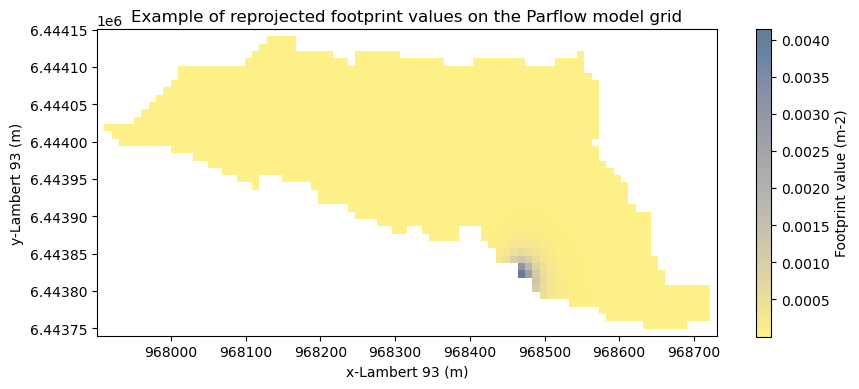

In [68]:
x = footprint_masked['x'].values
y = footprint_masked['y'].values

extent = [x.min(), x.max(), y.min(), y.max()]
          
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
im = ax.imshow(footprint_masked.values, origin='upper', extent=extent, cmap = 'cividis_r', alpha = 0.6) 
plt.title("Example of reprojected footprint values on the Parflow model grid")
plt.xlabel("x-Lambert 93 (m)")
plt.ylabel("y-Lambert 93 (m)")
plt.colorbar(im, ax=ax, label="Footprint value (m-2)")

plt.savefig('/home/jovyan//ICOS-M2-internship-alise/data_plots/reprojected_footprint_PF.png', bbox_inches='tight')
plt.show()

This image illustrates the transition from 2.5x2.5m footprint values to a 10x10m model grid. **To compare Parflow values with the flux measured by the ICOS tower, this reprojection will be systematic. We can deduce from this work the relevant importance of the watershed and the wetland in the reprojected footprint.**

# Conclusion

Footprint analyses are useful for calculating relative contribution of the watershed to the measured flux. **After a reprojection, comparing the observed H<sub>2</sub>O flux with the simulated data could help understand limitations of the model and improve its accuracy.**